In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from ssim_spearman_eval import ssim_corr_eval
from mae_no_cls import IF_MAE
from sklearn.manifold import TSNE
from skimage.io import imread
from ssim_spearman_eval import ssim_corr_eval
import gc
from torch.utils.data import DataLoader, Dataset

In [33]:
def show_memuse():
    alloc = torch.cuda.memory_allocated(device=torch.device('cuda:0')) / 1000 / 1000 / 1000
    res = torch.cuda.memory_reserved(device=torch.device('cuda:0')) / 1000 / 1000 / 1000
    print(alloc, res)

In [34]:
def tile_im(im):
    return np.concatenate(
        [np.concatenate([im[:,:,ch] for ch in range(i, i+5)], axis=1)  for i in range(0,21,5)], 
        axis=0)

In [35]:
class SingleCellDataset(Dataset):
    def __init__(self, files):
        self.img_files = files

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        filepath = self.img_files[idx]
        im = imread(filepath)
        #im = np.concatenate([np.concatenate([im[:,:,ch] for ch in range(i, i+5)], axis=1)  for i in range(0,21,5)], axis=0)
        tensor = torch.from_numpy(im)
        tensor = tensor.unsqueeze(0)
        tensor = tensor.float()

        return tensor

In [68]:
#data_dir = '/dev/shm/train/CRC-TMA'
data_dir='/home/groups/ChangLab/simsz/panel_reduction/data/train/TMA4-CellTilesTiled'
files = [f'{data_dir}/{f}' for f in os.listdir(data_dir)]

split = round(len(files) * 0.9)
val_files = files[split:]
val_data = SingleCellDataset(val_files)

BATCH_SIZE = 7000

In [69]:
val_loader = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        num_workers=8,
                        persistent_workers=True,
                        pin_memory=True)

In [70]:
ls -l /home/groups/ChangLab/simsz/panel_reduction/training/pt_mae/version_None/checkpoints

total 16227328
-rw-r--r-- 1 simsz ChangLab  710422983 Feb 22 18:37 'epoch=149-step=22950.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367223 Feb 23 17:13 'epoch=156-step=12089.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367223 Feb 23 17:14 'epoch=157-step=12166.ckpt'
-rw-r--r-- 1 simsz ChangLab 1391027404 Feb 22 23:11 'epoch=235-step=36108.ckpt'
-rw-r--r-- 1 simsz ChangLab 1391027404 Feb 22 23:12 'epoch=236-step=36261.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367287 Feb 23 20:24 'epoch=265-step=20482.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367287 Feb 23 20:25 'epoch=266-step=20559.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367287 Feb 23 14:48 'epoch=352-step=54009.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367223 Apr  5 23:52 'epoch=3-step=676.ckpt'
-rw-r--r-- 1 simsz ChangLab  937358269 Apr 13 12:36 'epoch=499-step=338000.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367287 Feb 23 05:39 'epoch=499-step=76500.ckpt'
-rw-r--r-- 1 simsz ChangLab  937367287 Feb 24 05:18 'epoch=499-step=76500-v1.ckpt'
-rw-r--r-- 1 simsz ChangL

In [71]:
ls -l ckpts

total 4408184
-rw-r--r-- 1 simsz ChangLab 937367287 Feb 23 20:32  50p_mask_12l_dec.ckpt
-rw-r--r-- 1 simsz ChangLab 937367287 Feb 23 14:54  75p_mask_12l_dec_499e.ckpt
-rw-r--r-- 1 simsz ChangLab 937367287 Apr 12 14:16 'CRC_TMA_50p_mask_cls_epoch=499-step=84500.ckpt'
-rw-r--r-- 1 simsz ChangLab 937358269 Apr 18 12:24 'CRC_TMA_50p_mask_no_cls_epoch=499-step=338000.ckpt'


In [72]:
ckpt = 'ckpts/CRC_TMA_50p_mask_no_cls_epoch=499-step=338000.ckpt'

In [73]:
model = IF_MAE().load_from_checkpoint(ckpt)
model = model.to(torch.device('cuda'))
model = model.eval()

In [42]:
import torch
from einops import rearrange, repeat
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import spearman_corrcoef as spearman

def ssim_corr_eval(ims, masked, preds):
    #reshape to BxCxHxW
    preds_unpatched = rearrange(preds, 'b c (h w) -> b c h w', h=32)
    masked_unpatched = rearrange(masked, 'b c (h w) -> b c h w', h=32)
    ims_unpatched = rearrange(ims.squeeze(1), 'b (c1 h) (c2 w) -> b (c1 c2) h w',h=32, w=32)

    #reconstruct cell nucleus mask by binarizing dapi channel
    dapi_mask = ims_unpatched[:,0].clone()
    dapi_mask[dapi_mask > 0] = 1
    #set zero values to nan so marker intensity inside cell boundary can easily be calculated with nanmean
    dapi_mask[dapi_mask == 0] = torch.nan

    #expand dapi mask to number of reconstructed channels
    dapi_mask = repeat(dapi_mask,'b h w -> b c h w', c=preds.shape[1])

    #"segment" cell images
    segged_channels = masked_unpatched * dapi_mask
    pred_segged_channels = preds_unpatched * dapi_mask

    #reconstructed image has values less than zero
    pred_segged_channels[pred_segged_channels < 0] = 0

    #calculate mean intensities
    mean_int = torch.nanmean(segged_channels, dim=(2,3))
    pred_mean_int = torch.nanmean(pred_segged_channels, dim=(2,3))

    if mean_int.shape[1] == 1:
        mean_int = mean_int.squeeze()
        pred_mean_int = pred_mean_int.squeeze()

    #set nan values back to zero to calculate SSIM
    pred_segged_channels[torch.isnan(pred_segged_channels).bool()] = 0
    segged_channels[torch.isnan(segged_channels).bool()] = 0

    #get ssim
    ssim_scores = ssim(masked_unpatched, pred_segged_channels, reduction=None)

    return ssim_scores, mean_int, pred_mean_int


In [43]:
def get_ssim_spearman(model, val_loader, masked_ch_idx):
    preds, masked = torch.tensor([]).to(torch.device('cuda')), torch.tensor([]).to(torch.device('cuda'))
    ssims = torch.tensor([]).to(torch.device('cuda'))
    mean_ints, pred_mean_ints = torch.tensor([]).to(torch.device('cuda')), torch.tensor([]).to(torch.device('cuda'))

    for batch in val_loader:
        with torch.no_grad():
            batch = batch.to(torch.device('cuda'))
            preds_, masked_ = model(batch,  masked_patch_idx=masked_ch_idx)
            #show_memuse()
            ssims_, mean_ints_, pred_mean_ints_ = ssim_corr_eval(batch, masked_, preds_)
            preds = torch.concat([preds, preds_])
            masked = torch.concat([masked, masked_])
            ssims = torch.concat([ssims, ssims_])
            mean_ints = torch.concat([mean_ints, mean_ints_])
            pred_mean_ints = torch.concat([pred_mean_ints, pred_mean_ints_])
            del batch
            gc.collect()
            torch.cuda.empty_cache()
    
    return torch.mean(ssims), torch.mean(spearman(mean_ints, pred_mean_ints)), (mean_ints, pred_mean_ints), spearman(mean_ints, pred_mean_ints)

In [44]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"NaKATPase", 3:"CD45RO", 4:"Ki67", 5:"panCK", 6:"aSMA", 7:"CD4", 8:"CD45",
            9:"PD-1", 10:"CD20", 11:"CD68", 12:"CD8a", 13:"CD163", 14:"FOXP3", 15:"PD-L1", 16:"ECad", 17:"Vim",
            18:"CDX2", 19:"LaminABC", 20:"Desmin", 21:"CD31", 22:"PCNA", 23:"Ki67", 24:"Collagen IV"}

In [28]:
def write_channel_order(val_loader, model):
    log = 'panel_logs/log_CRC_50p_12l_dec.txt'
    ch2stain = {0:"DAPI", 1:"CD3", 2:"NaKATPase", 3:"CD45RO", 4:"Ki67", 5:"panCK", 6:"aSMA", 7:"CD4", 8:"CD45",
                9:"PD-1", 10:"CD20", 11:"CD68", 12:"CD8a", 13:"CD163", 14:"FOXP3", 15:"PD-L1", 16:"ECad", 17:"Vim",
                18:"CDX2", 19:"LaminABC", 20:"Desmin", 21:"CD31", 22:"PCNA", 23:"Ki67", 24:"Collagen IV"}

    top_panel = [0]
    for num_masked in reversed(range(1,24)):
        masking_ratio = num_masked/25
        model.mae.masking_ratio = masking_ratio
        #with open(log, 'a') as f:
            #f.write(f'***best {25 - num_masked}  panel ***\n')
        top_corr = -999
        top_ch = None
        for ch_candidate in range(25):
            if ch_candidate in top_panel: continue
            candidate_panel = top_panel.copy()
            candidate_panel.append(ch_candidate)
            print(f'candidate panel:{[ch2stain[ch] for ch in candidate_panel]}')
            masked_ch_idx = torch.tensor([i for i in range(25) if i not in candidate_panel]).to(torch.device('cuda'))


            #show_memuse()
            ssim_score, corr,_,_ = get_ssim_spearman(model, val_loader, masked_ch_idx)
            #show_memuse()

            print(f'chosen  masking strategy: SSIM:{ssim_score} Spearman:{corr}')

            if corr > top_corr:
                print('found new top panel')
                top_corr = corr
                top_ch = ch_candidate

            gc.collect()
            torch.cuda.empty_cache()

        top_panel.append(top_ch)
        print(f'optimal panel so far: {[ch2stain[ch] for ch in top_panel]}')
        with open(log,'a') as f:
            f.write(f'{[ch2stain[ch] for ch in top_panel]}\n')
            f.write(f'{top_panel}\n')

In [29]:
write_channel_order(val_loader, model)

candidate panel:['DAPI', 'CD3']
chosen  masking strategy: SSIM:0.6546962261199951 Spearman:0.09282834827899933
found new top panel
candidate panel:['DAPI', 'NaKATPase']
chosen  masking strategy: SSIM:0.6576938629150391 Spearman:0.10388448089361191
found new top panel
candidate panel:['DAPI', 'CD45RO']
chosen  masking strategy: SSIM:0.6266862154006958 Spearman:0.12100955843925476
found new top panel
candidate panel:['DAPI', 'Ki67']
chosen  masking strategy: SSIM:0.6543576717376709 Spearman:0.13672123849391937
found new top panel
candidate panel:['DAPI', 'panCK']
chosen  masking strategy: SSIM:0.612554132938385 Spearman:0.06264474242925644
candidate panel:['DAPI', 'aSMA']
chosen  masking strategy: SSIM:0.6471177339553833 Spearman:0.020689325407147408
candidate panel:['DAPI', 'CD4']
chosen  masking strategy: SSIM:0.7064832448959351 Spearman:0.25565305352211
found new top panel
candidate panel:['DAPI', 'CD45']
chosen  masking strategy: SSIM:0.6527876257896423 Spearman:0.1274849772453308
ca

chosen  masking strategy: SSIM:0.7513425350189209 Spearman:0.29411277174949646
candidate panel:['DAPI', 'CD4', 'Desmin', 'Ki67']
chosen  masking strategy: SSIM:0.7421591281890869 Spearman:0.25363850593566895
candidate panel:['DAPI', 'CD4', 'Desmin', 'Collagen IV']
chosen  masking strategy: SSIM:0.7351034879684448 Spearman:0.3012794256210327
optimal panel so far: ['DAPI', 'CD4', 'Desmin', 'FOXP3']
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'CD3']
chosen  masking strategy: SSIM:0.7537221312522888 Spearman:0.32864925265312195
found new top panel
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'NaKATPase']
chosen  masking strategy: SSIM:0.7282202839851379 Spearman:0.31383809447288513
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'CD45RO']
chosen  masking strategy: SSIM:0.7512346506118774 Spearman:0.31696122884750366
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Ki67']
chosen  masking strategy: SSIM:0.753337562084198 Spearman:0.32071763277053833
candidate panel:['DAPI'

chosen  masking strategy: SSIM:0.7938691973686218 Spearman:0.371916264295578
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'CD163']
chosen  masking strategy: SSIM:0.7769948244094849 Spearman:0.37684834003448486
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PD-L1']
chosen  masking strategy: SSIM:0.7815794348716736 Spearman:0.3605087697505951
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'ECad']
chosen  masking strategy: SSIM:0.7746883034706116 Spearman:0.3787795305252075
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'Vim']
chosen  masking strategy: SSIM:0.7729371786117554 Spearman:0.34446290135383606
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'CDX2']
chosen  masking strategy: SSIM:0.7936611771583557 Spearman:0.3393288850784302
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'LaminABC']
chosen  masking strategy: SS

chosen  masking strategy: SSIM:0.7774896025657654 Spearman:0.44672784209251404
found new top panel
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'Ki67']
chosen  masking strategy: SSIM:0.7701572775840759 Spearman:0.4036200940608978
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'aSMA']
chosen  masking strategy: SSIM:0.7707424759864807 Spearman:0.43708473443984985
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45']
chosen  masking strategy: SSIM:0.7810395956039429 Spearman:0.4203138053417206
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'PD-1']
chosen  masking strategy: SSIM:0.7663971781730652 Spearman:0.4076901376247406
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD20']
chosen  masking strategy: SS

chosen  masking strategy: SSIM:0.7872369885444641 Spearman:0.4183347821235657
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'CDX2']
chosen  masking strategy: SSIM:0.7804596424102783 Spearman:0.4330756962299347
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'LaminABC']
chosen  masking strategy: SSIM:0.7834796905517578 Spearman:0.43480297923088074
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'Ki67']
chosen  masking strategy: SSIM:0.7871439456939697 Spearman:0.4587703049182892
optimal panel so far: ['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA']
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'CD3']
chosen  masking stra

chosen  masking strategy: SSIM:0.8088722229003906 Spearman:0.5190963745117188
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'Vim']
chosen  masking strategy: SSIM:0.8182218670845032 Spearman:0.4803197979927063
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CDX2']
chosen  masking strategy: SSIM:0.7739245295524597 Spearman:0.5069457292556763
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'LaminABC']
chosen  masking strategy: SSIM:0.8053728342056274 Spearman:0.501274049282074
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'Ki67']
chosen  masking strategy: SSIM:0.8169843554496765 Spearman:0.514520287

chosen  masking strategy: SSIM:0.8042847514152527 Spearman:0.5421774387359619
optimal panel so far: ['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163']
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'Ki67']
chosen  masking strategy: SSIM:0.7954846024513245 Spearman:0.5374574661254883
found new top panel
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'CD45']
chosen  masking strategy: SSIM:0.7946242690086365 Spearman:0.531941831111908
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'CD20']
c

chosen  masking strategy: SSIM:0.75779128074646 Spearman:0.47249042987823486
optimal panel so far: ['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'Ki67', 'CDX2', 'Ki67', 'CD20', 'Vim']
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'Ki67', 'CDX2', 'Ki67', 'CD20', 'Vim', 'CD45']
chosen  masking strategy: SSIM:0.7331928014755249 Spearman:0.5494446158409119
found new top panel
candidate panel:['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen IV', 'panCK', 'PCNA', 'CD68', 'NaKATPase', 'CD45RO', 'CD31', 'aSMA', 'PD-L1', 'CD3', 'CD8a', 'PD-1', 'ECad', 'CD163', 'Ki67', 'CDX2', 'Ki67', 'CD20', 'Vim', 'LaminABC']
chosen  masking strategy: SSIM:0.6695759892463684 Spearman:0.42204099893569946
optimal panel so far: ['DAPI', 'CD4', 'Desmin', 'FOXP3', 'Collagen

In [15]:
#iterative-selection panel
panel_channel_order = [0, 16, 9, 11, 22, 6, 12, 14, 21, 1, 15, 20, 3, 10, 24, 13, 4, 19, 7, 18, 23, 8, 17, 5]

In [19]:
show_memuse()

0.3193984 0.329252864


In [74]:
#iterative-selection panel (no cls token)
panel_channel_order = [0, 7, 20, 14, 24, 5, 22, 11, 2, 3, 21, 6, 15, 1, 12, 9, 16, 13, 23, 18, 4, 10, 17, 8]

In [46]:
from tqdm import tqdm

In [75]:
def test_model_with_panel_set(model, panel_sets):
    ssims = []
    corrs = []
    corr_sets = []
    for panel in tqdm(panel_sets):
        masked_ch_idx = torch.tensor([i for i in range(25) if i not in panel]).to(torch.device('cuda'))
        model.mae.masking_ratio = (25-len(panel))/25
        ssim_score, corr, _, corr_per_stain = get_ssim_spearman(model, val_loader, masked_ch_idx)
        ssims.append(torch.mean(ssim_score))
        corrs.append(corr)
        corr_sets.append(corr_per_stain)
        
        gc.collect()
        torch.cuda.empty_cache()

    return ssims, corrs, corr_sets

In [76]:
panel_set_iter = [panel_channel_order[:panel_size] for panel_size in range(1,25)]

In [77]:
ssims, corrs, corr_sets = test_model_with_panel_set(model, panel_set_iter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [1:37:32<00:00, 243.87s/it]


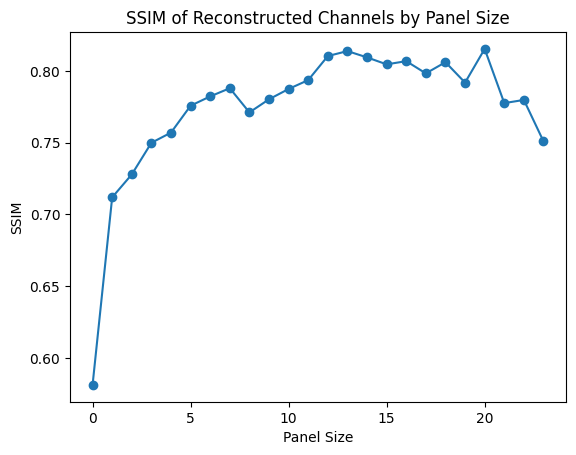

In [78]:
plt.plot(np.arange(24), [ssim.cpu() for ssim in ssims], marker='o')
plt.title('SSIM of Reconstructed Channels by Panel Size')
plt.xlabel('Panel Size')
plt.ylabel('SSIM')
#plt.savefig('plots/ssim.svg')
plt.show()

In [79]:
len(corr_sets)

24

In [80]:
corr_sets[0]

tensor([ 5.0773e-02,  5.3378e-02, -7.8754e-02,  6.8876e-02,  1.0538e-01,
        -4.2325e-02,  1.4774e-01, -7.0098e-02,  1.2102e-01,  8.2505e-02,
         7.9561e-03, -1.6315e-01,  6.3431e-02,  8.1045e-02,  4.1378e-02,
         7.0071e-02, -2.0908e-04,  3.0638e-02,  2.8125e-01,  6.5913e-02,
        -5.6722e-02,  1.4167e-01,  8.4911e-02, -7.3474e-02], device='cuda:0')

In [81]:
masked_chs = []
for panel_size in range(1,25):
    msk_chs = [i for i in range(25) if i not in panel_channel_order[:panel_size]]
    masked_chs.append(msk_chs)

corr_array = np.ones((25,25))
for i,(panel,panel_i) in enumerate(zip(corr_sets,masked_chs)):
    if i == 23:
        panel = [panel.item()]
        panel_i = list(panel_i)
    for j,(ch, ch_i) in enumerate(zip(panel,panel_i)):
        #print(i, ch_i, ch)
        corr_array[i][ch_i] = ch
        
iter_24_panel = panel_channel_order
still_masked = [i for i in range(25) if i not in iter_24_panel]
sorted_channels = iter_24_panel + still_masked

corr_array_sorted = np.zeros(corr_array.shape)
ch2stain_sorted = {}
for i,ch in  enumerate(sorted_channels):
    corr_array_sorted[:,i] = corr_array[:,ch]
    ch2stain_sorted[i] = ch2stain[ch]

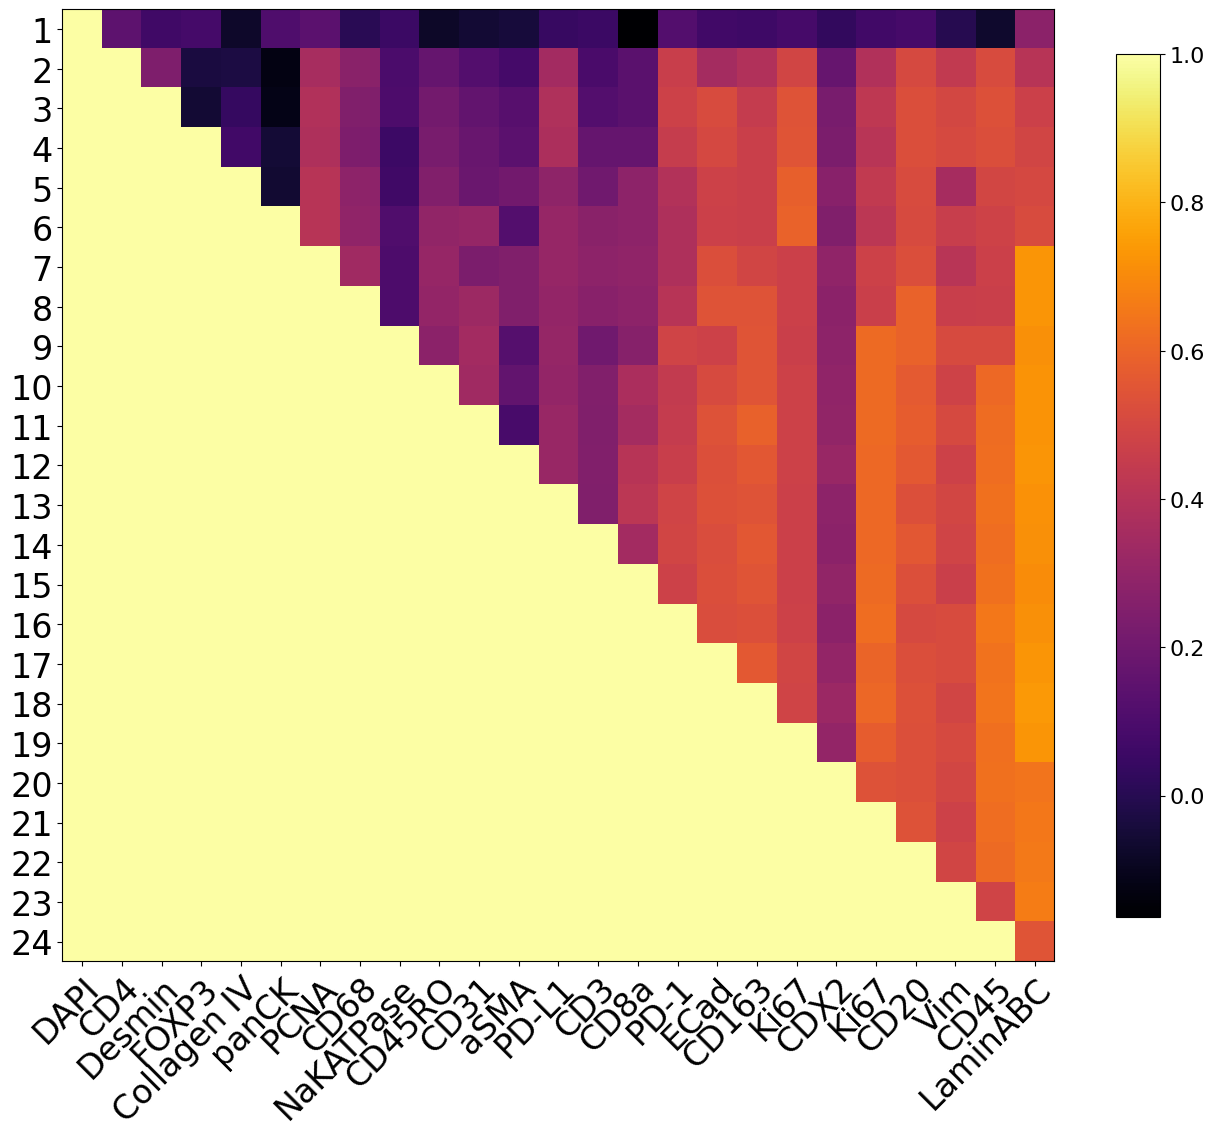

In [82]:
fig, ax = plt.subplots(figsize=(16,16))
img = corr_array_sorted[:24]
#img = np.expand_dims(img, 0)
im = ax.imshow(img, cmap='inferno')
ax.set_yticks(np.arange(24),[str(i+1) for i in range(24)], fontsize=24)
ax.set_xticks(np.arange(25), list(ch2stain_sorted.values()), fontsize=24)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = plt.colorbar(im, orientation='vertical', shrink = 0.7)
cbar.ax.tick_params(labelsize=16)
plt.savefig('plots/panel_selection.svg')
plt.show()

In [83]:
val_data_ = torch.concat([val_data[i] for i in range(10)]).unsqueeze(1)

In [84]:
panel = panel_channel_order[:9]
masked_ch_idx = torch.tensor([i for i in range(25) if i not in panel]).to(torch.device('cuda'))
model.mae.masking_ratio = (25-9)/25
with torch.no_grad():
    targets,preds = model.forward(val_data_.to(torch.device('cuda')), masked_patch_idx=masked_ch_idx)

In [85]:
ims = val_data_.clone()
#preds = rearrange(preds, 'b c (h w) -> b h w c', h=32)
#targets = rearrange(targets, 'b c (h w) -> b h w c', h=32)
orig = rearrange(val_data_.squeeze(1), 'b (c1 h) (c2 w) -> b (c1 c2) h w',h=32, w=32)
preds[preds < 0] = 0

In [86]:
def view_rgb_image(sample_i, ch1_i, ch2_i, ch3_i):
    ch1 = preds[sample_i,:,:, ch1_i].unsqueeze(2).cpu()
    ch1_o = targets[sample_i,:,:,ch1_i].unsqueeze(2).cpu()
    ch2 = preds[sample_i,:,:, ch2_i].unsqueeze(2).cpu()
    ch2_o = targets[sample_i,:,:,ch2_i].unsqueeze(2).cpu()
    ch3 = preds[sample_i,:,:, ch3_i].unsqueeze(2).cpu()
    ch3_o = targets[sample_i,:,:,ch3_i].unsqueeze(2).cpu()

    fig, ax = plt.subplots(1,8, figsize=(32,32))
    
    blank = np.zeros(ch1.shape)
    ax[0].imshow(np.concatenate([ch1, blank, blank], axis=2).astype('uint8'))
    ax[1].imshow(np.concatenate([ch1_o, blank, blank], axis=2).astype('uint8'))
    ax[2].imshow(np.concatenate([blank, ch2, blank], axis=2).astype('uint8'))
    ax[3].imshow(np.concatenate([blank, ch2_o, blank], axis=2).astype('uint8'))
    ax[4].imshow(np.concatenate([blank, blank, ch3], axis=2).astype('uint8'))
    ax[5].imshow(np.concatenate([blank, blank, ch3_o], axis=2).astype('uint8'))
    ax[6].imshow(np.concatenate([ch1, ch2, ch3], axis=2).astype('uint8'))
    ax[7].imshow(np.concatenate([ch1_o, ch2_o, ch3_o], axis=2).astype('uint8'))
    
    ax[0].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[1].set_title(f'Real\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[2].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[3].set_title(f'Real\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[4].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[5].set_title(f'Real\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[6].set_title('Reconstructed\n Composite', fontsize=24)
    ax[7].set_title('Real\n Composite', fontsize=24)
    for a in fig.axes:
        a.axis('off')
    plt.savefig(f'plots/recon_panel_{ch1_i}.svg',bbox_inches='tight')
    plt.show()

In [87]:
from itertools import combinations, permutations
from random import shuffle

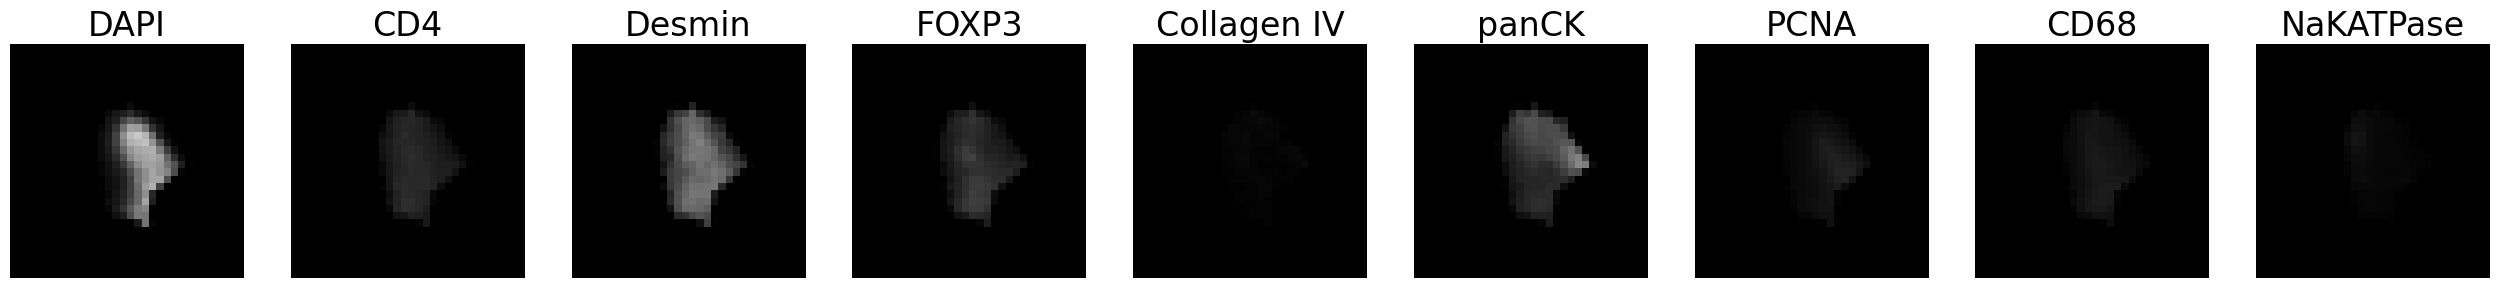

In [88]:
fig, ax = plt.subplots(1, len(panel), figsize=(32,32))
for a,i in zip(fig.axes, panel):
    a.set_title(f'{ch2stain[i]}', fontsize=24)
    ch = orig[1,i,:,:].unsqueeze(2).cpu().numpy().astype('uint8')
    a.imshow(np.concatenate([ch, ch, ch], axis=2))
    a.axis('off')
#plt.savefig('plots/panel_ex.svg',bbox_inches='tight')

In [89]:
l = [4, 0, 3, 12, 1, 15, 11, 9, 2, 6, 14, 7, 8, 13, 10, 5]

In [90]:
ssims

[tensor(0.5813, device='cuda:0'),
 tensor(0.7119, device='cuda:0'),
 tensor(0.7279, device='cuda:0'),
 tensor(0.7499, device='cuda:0'),
 tensor(0.7570, device='cuda:0'),
 tensor(0.7758, device='cuda:0'),
 tensor(0.7823, device='cuda:0'),
 tensor(0.7880, device='cuda:0'),
 tensor(0.7711, device='cuda:0'),
 tensor(0.7803, device='cuda:0'),
 tensor(0.7874, device='cuda:0'),
 tensor(0.7936, device='cuda:0'),
 tensor(0.8104, device='cuda:0'),
 tensor(0.8138, device='cuda:0'),
 tensor(0.8094, device='cuda:0'),
 tensor(0.8046, device='cuda:0'),
 tensor(0.8068, device='cuda:0'),
 tensor(0.7983, device='cuda:0'),
 tensor(0.8061, device='cuda:0'),
 tensor(0.7919, device='cuda:0'),
 tensor(0.8153, device='cuda:0'),
 tensor(0.7776, device='cuda:0'),
 tensor(0.7798, device='cuda:0'),
 tensor(0.7510, device='cuda:0')]

In [91]:
already_used = []
l = list(range(16))
shuffle(l)
for i in range(7):
    for ch1, ch2, ch3 in combinations([i for i in l if i not in already_used], 3):
        view_rgb_image(1, ch1, ch2, ch3)
        already_used.extend([ch1, ch2, ch3])
        break

IndexError: too many indices for tensor of dimension 3

In [ ]:
ch2stain[torch.tensor(0).item()]

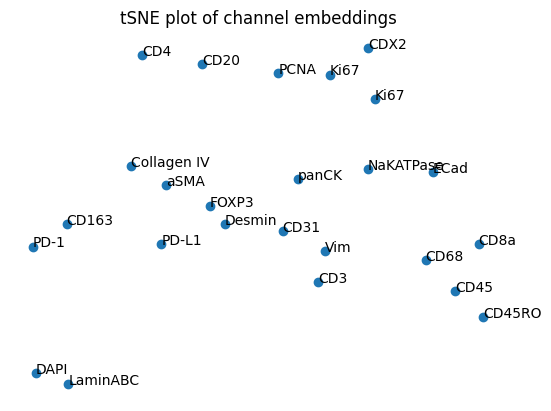

In [92]:
tsne = TSNE(n_components=2, perplexity=3).fit_transform(model.mae.encoder.pos_embedding.detach().cpu().numpy()[0][1:])
X = tsne[:,0]
Y = tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(X, Y)

for i in range(25):
    ax.annotate((ch2stain[i]), (X[i], Y[i]))
plt.title('tSNE plot of channel embeddings')
ax.axis('off')
plt.savefig('plots/tsne.svg')
plt.show()

In [93]:
def plot_intensities(model, val_loader, panel_set):
    masked_ch_idx = torch.tensor([i for i in range(25) if i not in panel]).to(torch.device('cuda'))
    model.mae.masking_ratio = (25-len(panel))/25
    

    ssim_score, corr, (mean_int, pred_mean_int), stain_corrs = get_ssim_spearman(model, val_loader, masked_ch_idx)
    
    fig, ax = plt.subplots(1,25 - len(panel), figsize=(12*(25-len(panel)),12), layout='tight')
    for i,a in enumerate(fig.axes):
        a.set_title(f'{ch2stain[masked_ch_idx[i].item()]}\n(⍴={round(stain_corrs[i].item(),2)})', fontsize=120)
        a.scatter(mean_int[:,i].cpu(), pred_mean_int[:,i].cpu())
        a.set_xticks([])
        a.set_yticks([])
    plt.savefig(f'plots/intensities_panel_{len(panel_set)}.svg')
    plt.show()

In [94]:
val_data_.shape

torch.Size([10, 1, 160, 160])

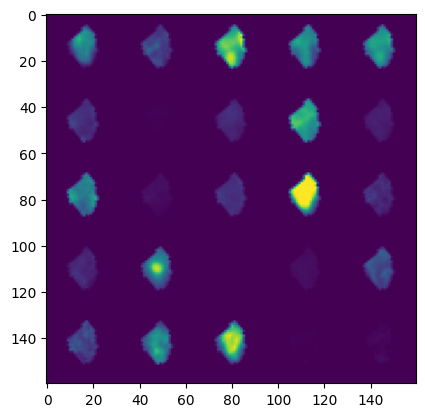

In [95]:
plt.imshow(val_data_[0][0])

/home/groups/ChangLab/simsz/panel_reduction/eval/mae_no_cls.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_indices = repeat(torch.tensor(masked_patch_idx), 'd -> b d', b=batch)
/home/groups/ChangLab/simsz/panel_reduction/eval/mae_no_cls.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unmasked_indices = repeat(torch.tensor(unmasked_patch_idx), 'd -> b d', b=batch)


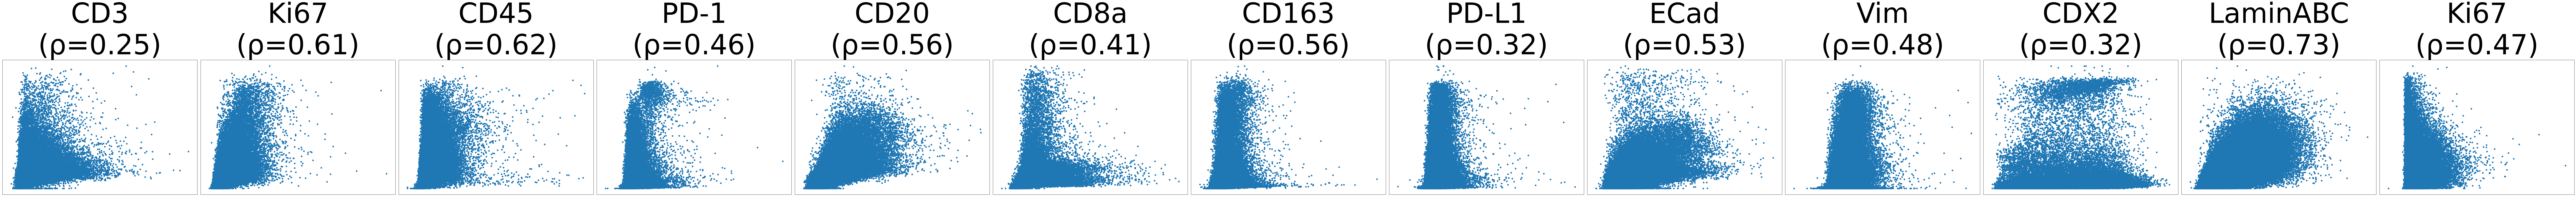

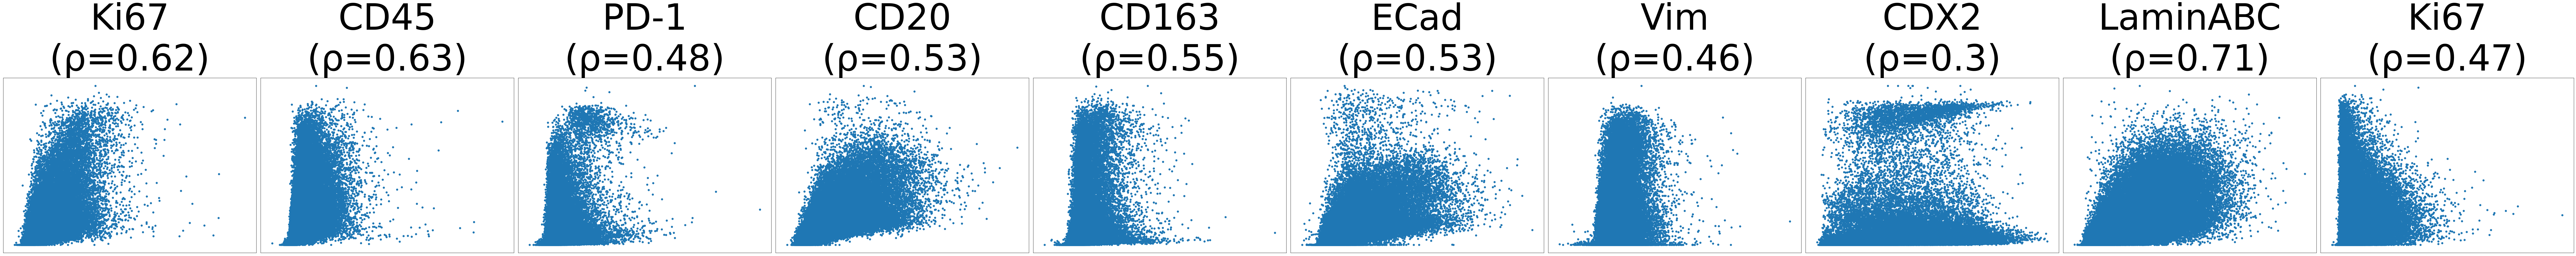

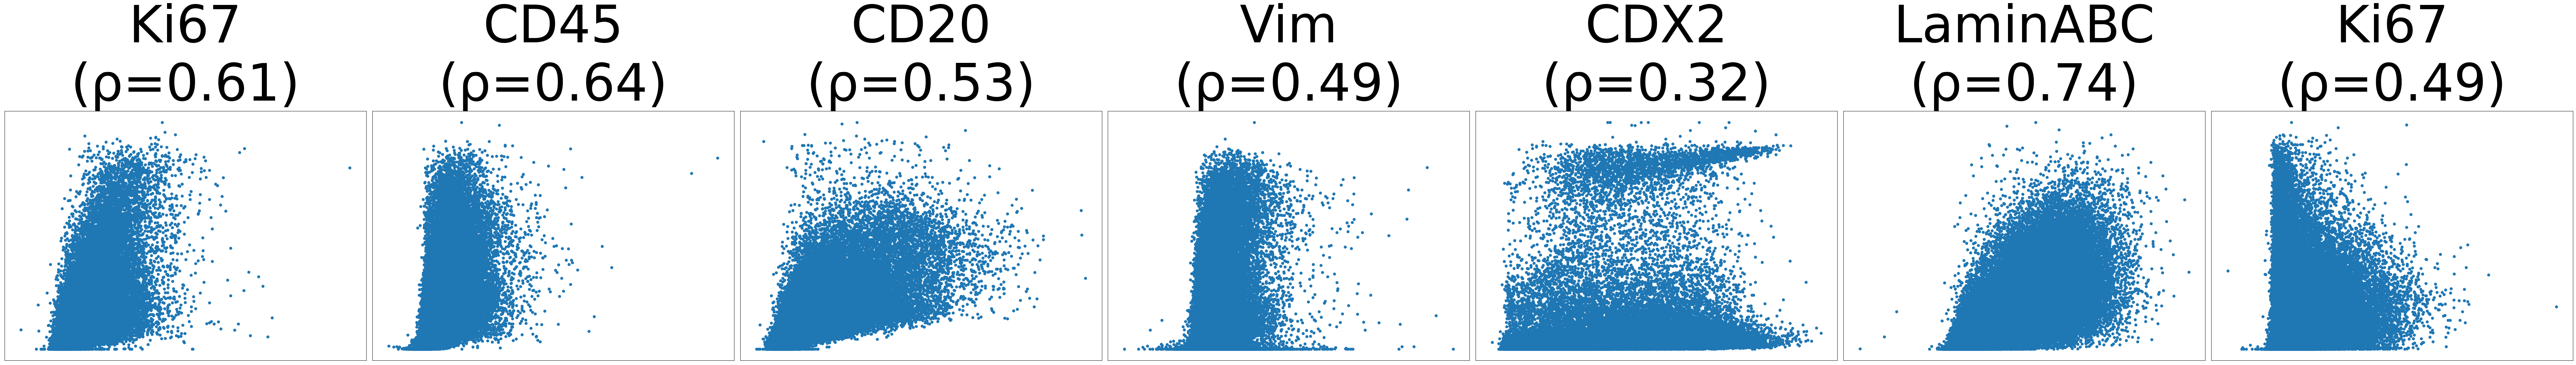

In [96]:
panel_sets = [panel_channel_order[:panel_size] for panel_size in [12,15,18]]
for panel in panel_sets:
    plot_intensities(model, val_loader, panel)

In [79]:
preds.shape

torch.Size([10, 32, 32, 16])

In [80]:
val_data_.shape

torch.Size([10, 1, 160, 160])

In [13]:
from mae_return_attn import IF_MAE

In [14]:
model = IF_MAE().load_from_checkpoint(ckpt)
model = model.to(torch.device('cuda'))
model = model.eval()

In [15]:
from tqdm import tqdm

In [16]:
attn_maps = torch.tensor([], device=torch.device('cuda'))
for batch in tqdm(val_loader):
    model.mae.masking_ratio = 0
    with torch.no_grad():
        batch = batch.to(torch.device('cuda'))
        attn_maps_ = model(batch)
    attn_maps = torch.concat([attn_maps, attn_maps_], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:37<00:00, 39.58s/it]


In [17]:
attn_maps = torch.mean(attn_maps, axis=1)

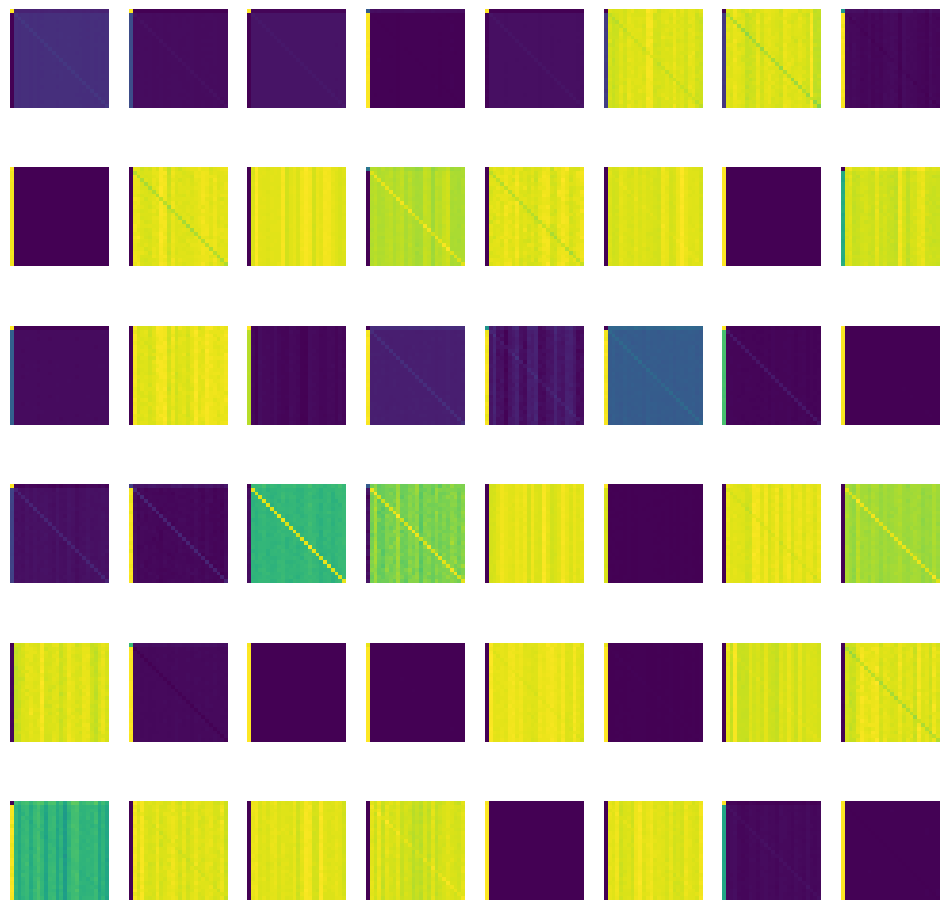

In [18]:
#crc 75p mask no cls (?)
fig, ax = plt.subplots(6,8, figsize=(12,12))
for i,a in enumerate(fig.axes):
    a.imshow(rearrange(attn_maps, 'd n h w -> (d n) h w')[i].cpu())
    a.axis('off')

In [21]:
attn_maps.shape

torch.Size([6, 8, 26, 26])

In [20]:
attn_maps.mean(axis=[0,1,2])

tensor([0.1662, 0.0334, 0.0332, 0.0334, 0.0334, 0.0331, 0.0333, 0.0334, 0.0335,
        0.0335, 0.0332, 0.0336, 0.0335, 0.0333, 0.0330, 0.0335, 0.0336, 0.0333,
        0.0333, 0.0332, 0.0337, 0.0334, 0.0334, 0.0332, 0.0331, 0.0333],
       device='cuda:0')

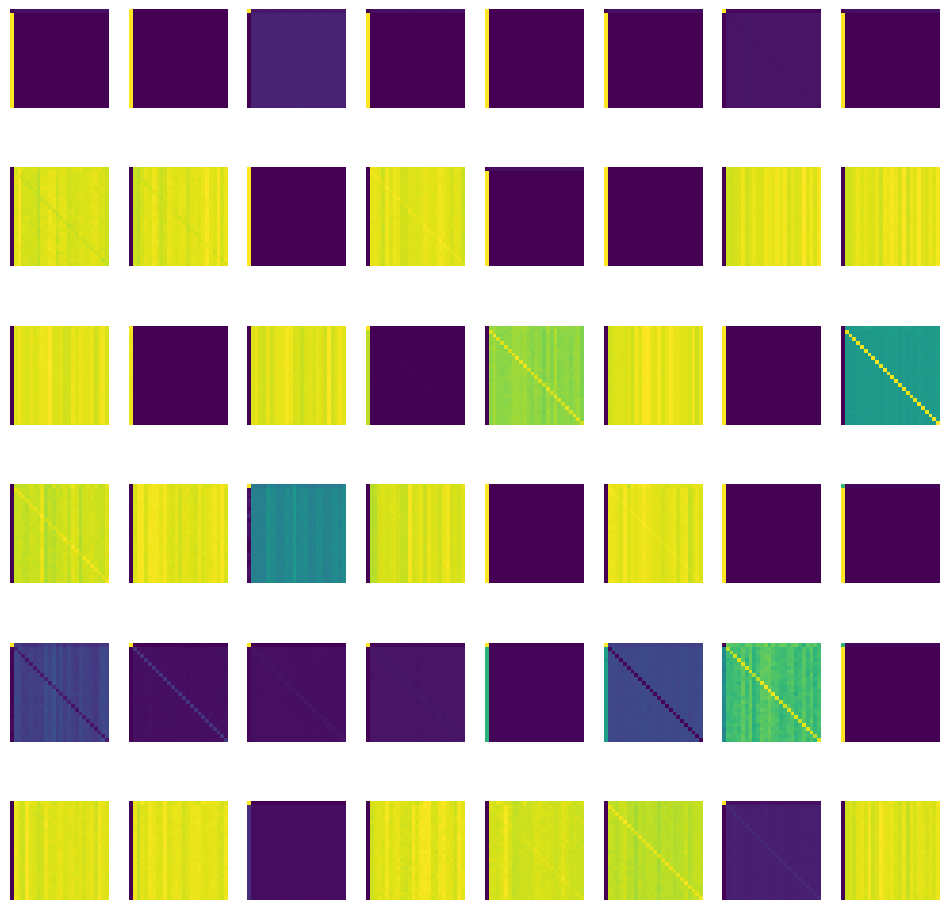

In [26]:
#BC 75p mask
fig, ax = plt.subplots(6,8, figsize=(12,12))
for i,a in enumerate(fig.axes):
    a.imshow(rearrange(attn_maps, 'd n h w -> (d n) h w')[i].cpu())
    a.axis('off')

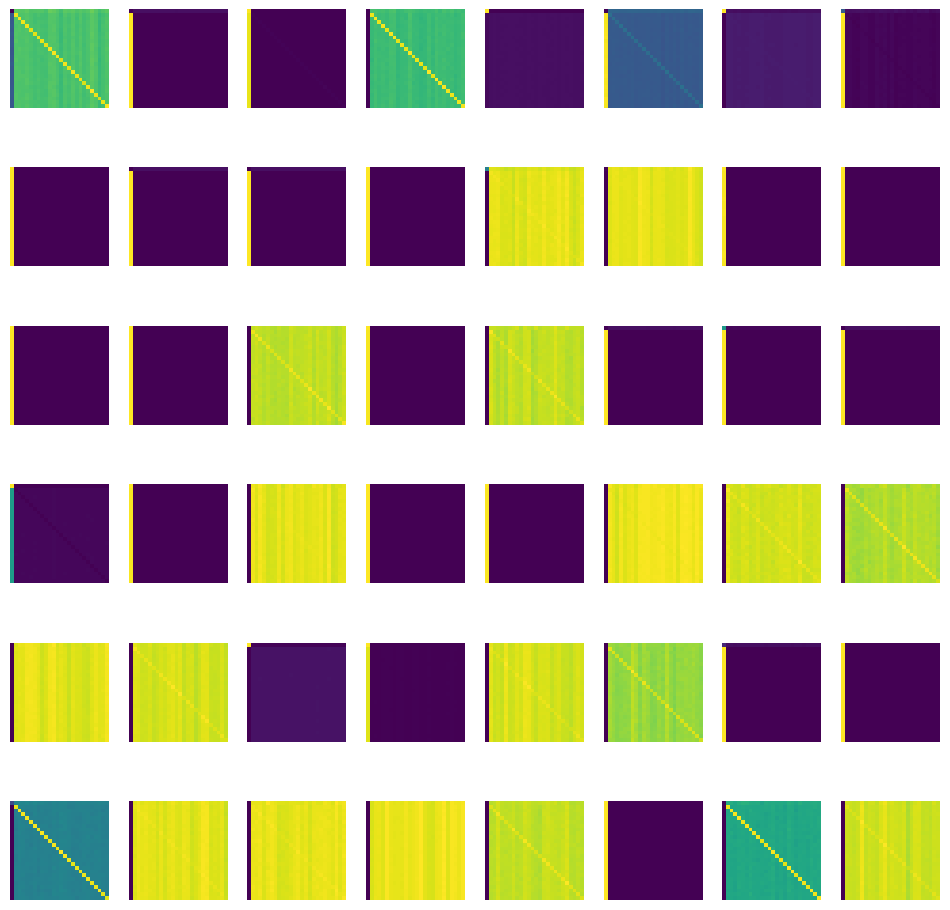

In [21]:
#BC 50p mask
fig, ax = plt.subplots(6,8, figsize=(12,12))
for i,a in enumerate(fig.axes):
    a.imshow(rearrange(attn_maps, 'd n h w -> (d n) h w')[i].cpu())
    a.axis('off')

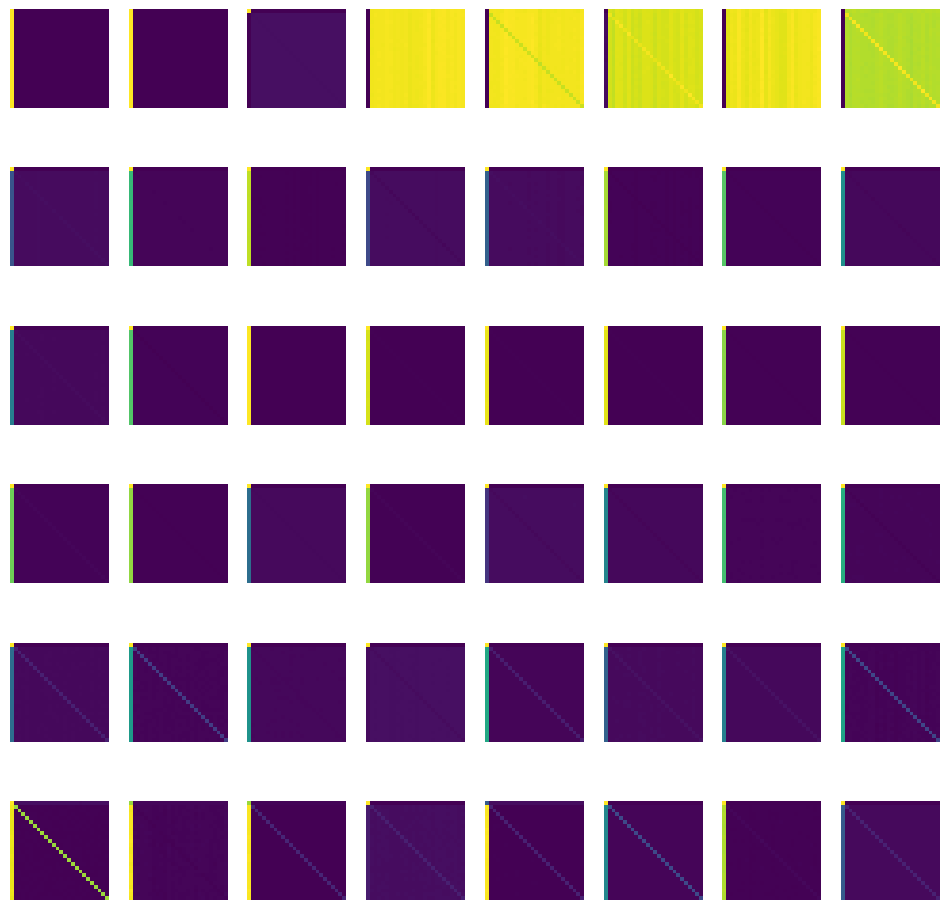

In [26]:
#CRC
fig, ax = plt.subplots(6,8, figsize=(12,12))
for i,a in enumerate(fig.axes):
    a.imshow(rearrange(attn_maps, 'd n h w -> (d n) h w')[i].cpu())
    a.axis('off')

In [102]:
torch.zeros(1, device='cpu')

tensor([0.])